In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
air_reserve = pd.read_csv("air_reserve.csv")
hpg_reserve = pd.read_csv("hpg_reserve.csv")
air_store = pd.read_csv("air_store_info.csv")
hpg_store = pd.read_csv("hpg_store_info.csv")
store_id_lookup = pd.read_csv("store_id_relation.csv")
air_visits = pd.read_csv("air_visit_data.csv")
date_info = pd.read_csv("date_info.csv")
stores_to_pred = pd.read_csv("sample_submission.csv")

# full.visit_date
Year, month, weekday, etx

In [3]:
# full 데이터 불러오기
full = pd.read_csv('scratch/full.csv', parse_dates=['visit_date'])

In [4]:
display(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284127 entries, 0 to 284126
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   dataset       284127 non-null  object        
 1   air_store_id  284127 non-null  object        
 2   visit_date    284127 non-null  datetime64[ns]
 3   visitors      284127 non-null  int64         
 4   id            284127 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 10.8+ MB


None

In [5]:
# 날짜로부터 가져올 수 있는 변수들 추가(요일, 년도, 월, 일, 월 마지막날 여부)
full['weekday'] = full.visit_date.dt.dayofweek
full['year'] = full.visit_date.dt.year
full['month'] = full.visit_date.dt.month
full['day_of_year'] = full.visit_date.dt.dayofyear
full['is_month_end'] = full.visit_date.dt.is_month_end

In [6]:
full.head()

,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,is_month_end
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,False
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,False
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,False
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,False
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,False


# date_info(holiday)

In [7]:
# date_info 데이터 불러오기
holiday_info = pd.read_csv('date_info.csv',  
                           parse_dates=['calendar_date'])

In [8]:
holiday_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [9]:
# 전일, 익일의 휴일 여부
holiday_info['tomorrow_is_holiday'] = holiday_info.holiday_flg.shift(-1).fillna(0).astype(int)
holiday_info['yesterday_is_holiday'] = holiday_info.holiday_flg.shift(1).fillna(0).astype(int)

In [10]:
# full에 merge
full = pd.merge(left=full, 
                right=holiday_info.drop('day_of_week', axis=1), 
                how='left', 
                left_on='visit_date', right_on='calendar_date')\
        .drop('calendar_date', axis=1)

In [11]:
full.head()

,dataset,air_store_id,visit_date,visitors,id,weekday,year,month,day_of_year,is_month_end,holiday_flg,tomorrow_is_holiday,yesterday_is_holiday
0,past,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,2016,1,13,False,0,0,0
1,past,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,2016,1,14,False,0,0,0
2,past,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,2016,1,15,False,0,0,0
3,past,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,2016,1,16,False,0,0,0
4,past,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,2016,1,18,False,0,0,0


# Stores

In [12]:
full.shape

(284127, 13)

In [13]:
# stores 데이터 불러오기
stores = pd.read_csv('scratch/stores.csv')

In [14]:
# 지역명 분류
area_split = stores.air_area_name.str.split(' ', expand=True)

stores['Todofuken'] = area_split[0]
stores['city'] = area_split[1]
stores['street'] = area_split.iloc[:, 2:].apply(lambda row: ' '.join(row.dropna()), axis=1)

In [15]:
# 현, 시, 거리명에 따라 동일한 지역의 개수
n_stores_by_street = stores.groupby(['air_area_name']).size().to_frame(name='n_stores_same_street').reset_index()
n_stores_by_city = stores.groupby(['Todofuken', 'city']).size().to_frame(name='n_stores_same_city').reset_index()
n_stores_by_Todofuken = stores.groupby('Todofuken').size().to_frame(name='n_stores_same_Todofuken').reset_index()

In [16]:
# full에 merge
stores = pd.merge(left=stores, right=n_stores_by_street, how='left', on='air_area_name')
stores = pd.merge(left=stores, right=n_stores_by_city, how='left', on=['Todofuken', 'city'])
stores = pd.merge(left=stores, right=n_stores_by_Todofuken, how='left', on='Todofuken')
full = pd.merge(left=full, right=stores, how='left', on='air_store_id')

In [17]:
full.shape

(284127, 23)

# Reserve

In [18]:
# reserves 불러오기
reserves = pd.read_csv('scratch/reserves.csv', parse_dates=['visit_datetime', 'reserve_datetime'])

In [19]:
display(reserves.head())
display(reserves.info())

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120561 entries, 0 to 120560
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      120561 non-null  object        
 1   visit_datetime    120561 non-null  datetime64[ns]
 2   reserve_datetime  120561 non-null  datetime64[ns]
 3   reserve_visitors  120561 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 3.7+ MB


None

## 예약건수, 방문자수, time gap

당일예약이 가능한 곳은 평범한 식당이고 **오래 전에 예약을 하는 곳이면 사람이 붐비는 식당일 확률이 높을 것**입니다. 방문시간과 예약시간의 차를 구해 변수로 추가하겠습니다.

In [20]:
# 방문시간과 예약시간의 차이를 hour과 day 단위로 분리
reserves['datetime_gap'] = reserves['visit_datetime'] - reserves['reserve_datetime']
reserves['hours_gap'] = reserves['datetime_gap'] / pd.Timedelta('1 hour')
reserves['days_gap'] = reserves['datetime_gap'].apply(lambda x: x.days)

In [21]:
# full과 합칠 때 필요한 date 변수 만들어주기
reserves['visit_date'] = reserves.visit_datetime.dt.date.astype('datetime64[ns]')

Input data로 식당, 날짜별 변수들이 들어가야 합니다. groupby를 통해 원하는 변수들을 만들어주겠습니다.

In [22]:
# 예약건수, 방문자수, 방문시간 - 예약시간의 평균(hour) 추가
reserve_summary = reserves.groupby(['air_store_id', 'visit_date'])\
                        [['reserve_visitors', 'hours_gap']]\
                        .agg({'reserve_visitors': ['count','sum'], 'hours_gap': 'mean'})\
                        .reset_index()
reserve_summary.columns=['air_store_id', 'visit_date', 
                     'n_reserves', 'n_reserve_visitors', 'reserve_avg_hours_ahead']
reserve_summary.head()

,air_store_id,visit_date,n_reserves,n_reserve_visitors,reserve_avg_hours_ahead
0,air_00a91d42b08b08d9,2016-01-14,1,2,77.0
1,air_00a91d42b08b08d9,2016-01-15,1,4,142.0
2,air_00a91d42b08b08d9,2016-01-16,1,2,70.0
3,air_00a91d42b08b08d9,2016-01-22,1,2,82.0
4,air_00a91d42b08b08d9,2016-01-29,1,5,144.0


## max_reserve_visitors

장사가 잘 된다는 가정 하에 넓은 공간과 많은 좌석수를 가졌다면 더 많은 방문자 수를 달성할 수 있을 것입니다. 따라서, **식당의 규모**는 방문자 수 예측에 도움이 되겠지만 이에 대한 명확한 지표가 없습니다. 다수가 한 번에 예약할 수 있는 곳이라면 식당의 규모도 클 확률이 높으므로 **식당별 예약자 수의 최댓값**이 방문자 수와 비례관계를 가지는지 알아보겠습니다.

In [23]:
# 식당별 한 건의 예약 기준 최대 예약자 수
max_vistor = reserves.groupby(['air_store_id'])['reserve_visitors'].max()
max_visitor = max_vistor.to_frame()

# 식당별 평균 방문자 수
full_for_plot = full.groupby(['air_store_id'])['visitors'].mean().reset_index()

# merge
max_visitor_plot = pd.merge(max_visitor, full_for_plot, how='left', on='air_store_id')

In [24]:
max_visitor_plot.corr()

,reserve_visitors,visitors
reserve_visitors,1.000000,0.346617
visitors,0.346617,1.000000


<AxesSubplot:xlabel='reserve_visitors', ylabel='visitors'>

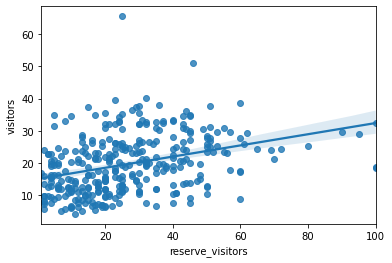

In [25]:
sns.regplot(x='reserve_visitors', y='visitors', data=max_visitor_plot)

In [26]:
z=np.polyfit(max_visitor_plot['reserve_visitors'], max_visitor_plot['visitors'], 1) # 기울기와 절편 확인
print("기울기: {}, 절편: {}".format(z[0], z[1]))

기울기: 0.17318099586423974, 절편: 15.095893888581712


**0.34의 상관관계**를 가지며 선형회귀선을 도출해본 결과 **0.17의 기울기**를 가져미세하게 증가하는 모양을 보이고 있습니다. 명확하게 관계가 있다고 보기는 어렵지만 변수로 한 번 추가해보겠습니다.

In [27]:
# reserve_summary에 max_reserve_visitors 변수 추가
reserve_summary = pd.merge(reserve_summary, max_visitor, how='left', on='air_store_id')
reserve_summary.rename(columns = {'reserve_visitors':'max_reserve_visitors'}, inplace=True)

In [28]:
# full에 merge
full = pd.merge(left=full, right=reserve_summary, how='left', 
                on=['air_store_id', 'visit_date'])

# Feature Analysis

## 1. 레스토랑 별 일 평균 방문자 수

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


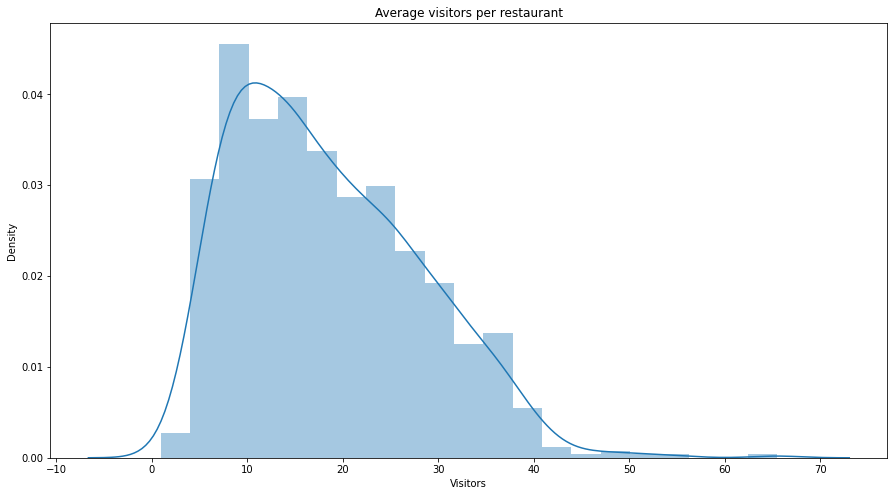

In [257]:
import seaborn as sns

temp = full.groupby(['air_store_id'])['visitors'].mean().to_frame()

f,ax = plt.subplots(1,1, figsize=(15,8))
sns.distplot(a=temp.visitors.values, ax=ax)
plt.xlabel('Visitors')
plt.ylabel('Density')
plt.title('Average visitors per restaurant')
plt.show()

In [258]:
group_by_cols = ['air_store_id']

visitor  = full\
                .query('dataset == "past"')\
                .groupby(group_by_cols)\
                ['visitors']\
                .agg(['mean', 'median', 'min', 'max'])\
                .rename(columns=lambda colname: str(colname)+'_visitors')\
                .reset_index()

In [259]:
visitor.head()

,air_store_id,mean_visitors,median_visitors,min_visitors,max_visitors
0,air_00a91d42b08b08d9,26.081897,26.0,1,99
1,air_0164b9927d20bcc3,9.248322,8.0,1,27
2,air_0241aa3964b7f861,9.896465,9.0,1,48
3,air_0328696196e46f18,7.939655,6.0,1,41
4,air_034a3d5b40d5b1b1,14.828685,12.0,1,116


In [260]:
visitor['mean_visitors'].mean()

21.20388676889276

In [261]:
visitor['mean_visitors'].min()

1.1875

In [262]:
visitor['mean_visitors'].max()

115.47058823529412

In [263]:
visitor['mean_visitors'].median()

19.183406113537117

### Observations

1. 식당별 일평균 방문자수는 **최소 1명, 최대 115명**까지 차이가 있다.
2. 모든 레스토랑 당 일평균 방문자수는 **약 21명**이다.
3. 방문자의 분포는 20명 미만에 몰려 있어 오른쪽으로 내려가는 모양이다.
4. 식당별 방문자수의 중앙값은 19이므로 수용인원이 **20명 미만인 식당이 많다.**

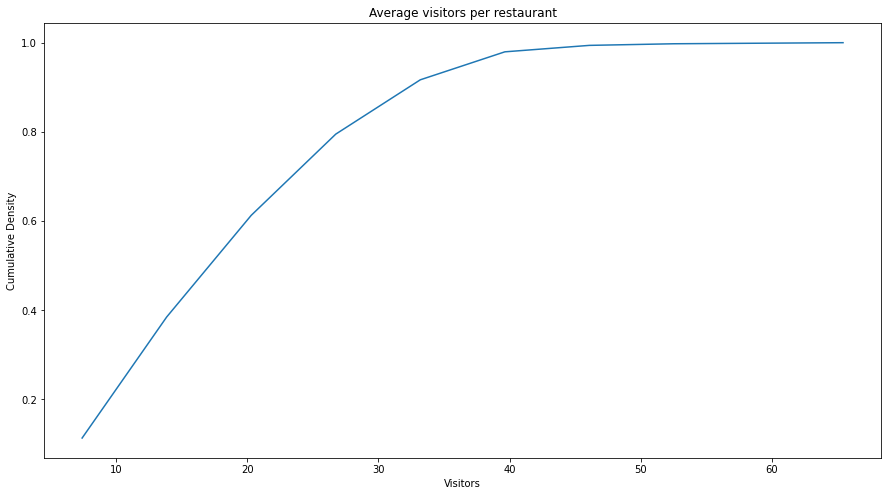

In [264]:
# 누적확률밀도함수
f,ax = plt.subplots(1,1, figsize=(15,8))
counts, bin_edges = np.histogram(temp['visitors'], bins=10, 
                                 density = True)

pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.ylabel('Cumulative Density')
plt.xlabel('Visitors')
plt.title('Average visitors per restaurant')
plt.show()

### Observations

1. **식당의 90%는 하루 방문객이 40명 미만**이다.
2. 손님 수용 인원이 **작은 식당이 많은 편**임을 알 수 있다.
3. 60명 이상의 방문객을 수용할 수 있는 크기의 식당은 거의 없다.

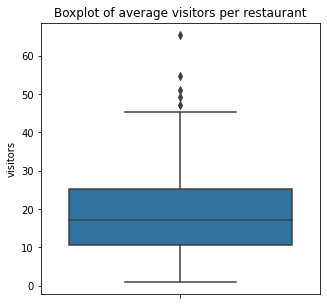

In [265]:
f,ax = plt.subplots(1,1, figsize=(5,5))
sns.boxplot(y='visitors', data=temp,ax=ax)
plt.title('Boxplot of average visitors per restaurant')
plt.show()

### Observations

1. 최소 방문객 수는 약 1명
2. 방문객의 중앙값은 18명 정도이다.
3. 최대 방문객 수는 60명 이상인 값이 하나 있고, 50명 대에 가까워지는 수치는 평균보다 높은 이상치로 보인다.
4. 25번째 백분위수와 75번째 백분위수 값은 각각 12(수치)과 26(수치) 정도입니다.

## 2.월별 평균 방문자 수

In [266]:
group_by_cols = ['month']

months_visitor  = full\
                .query('dataset == "past"')\
                .groupby(group_by_cols)\
                ['visitors']\
                .agg(['mean', 'median', 'min', 'max'])\
                .rename(columns=lambda colname: str(colname)+'_visitors')\
                .reset_index()

In [267]:
months_visitor

,month,mean_visitors,median_visitors,min_visitors,max_visitors
0,1,19.976758,16,1,514
1,2,20.477695,17,1,261
2,3,22.400360,18,1,877
3,4,21.816002,18,1,777
4,5,22.009313,18,1,311
5,6,21.319510,17,1,228
6,7,21.267653,17,1,675
7,8,19.748489,16,1,627
8,9,19.908445,16,1,325
9,10,20.319715,17,1,201


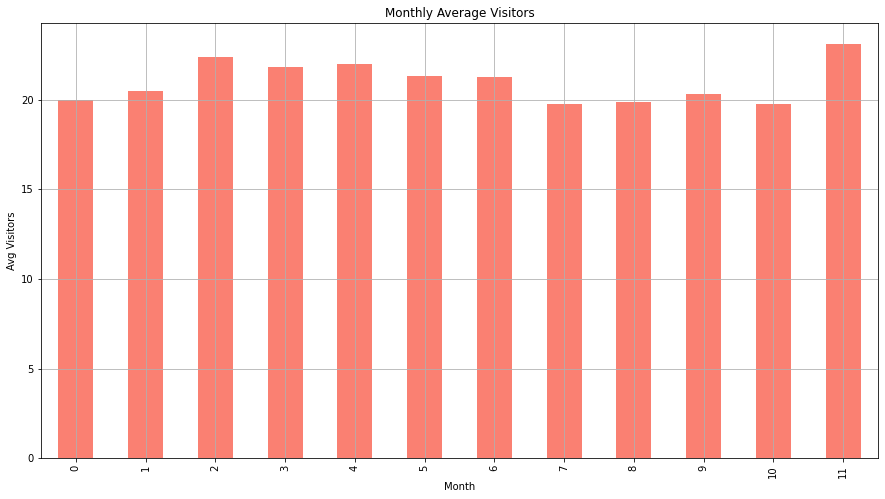

In [268]:
f, ax=plt.subplots(1,1, figsize=(15,8))
months_visitor['mean_visitors'].plot(kind='bar',color= 'salmon', grid=True, ax=ax,legend=False)
plt.xlabel('Month')
plt.ylabel('Avg Visitors')
plt.title('Monthly Average Visitors')
plt.show()

### Observations

1. **12월**에 가장 많은 방문객 수
2. 12월에는 특별한 휴일이 많은 달임
3. 그 다음으로 3월이 가장 많은 달이다.

## 3. 식당 종류별 점유율

In [269]:
air_store_info = pd.read_csv("air_store_info.csv")
temp = air_store_info.groupby(['air_genre_name'],as_index=False)['air_store_id'].count()

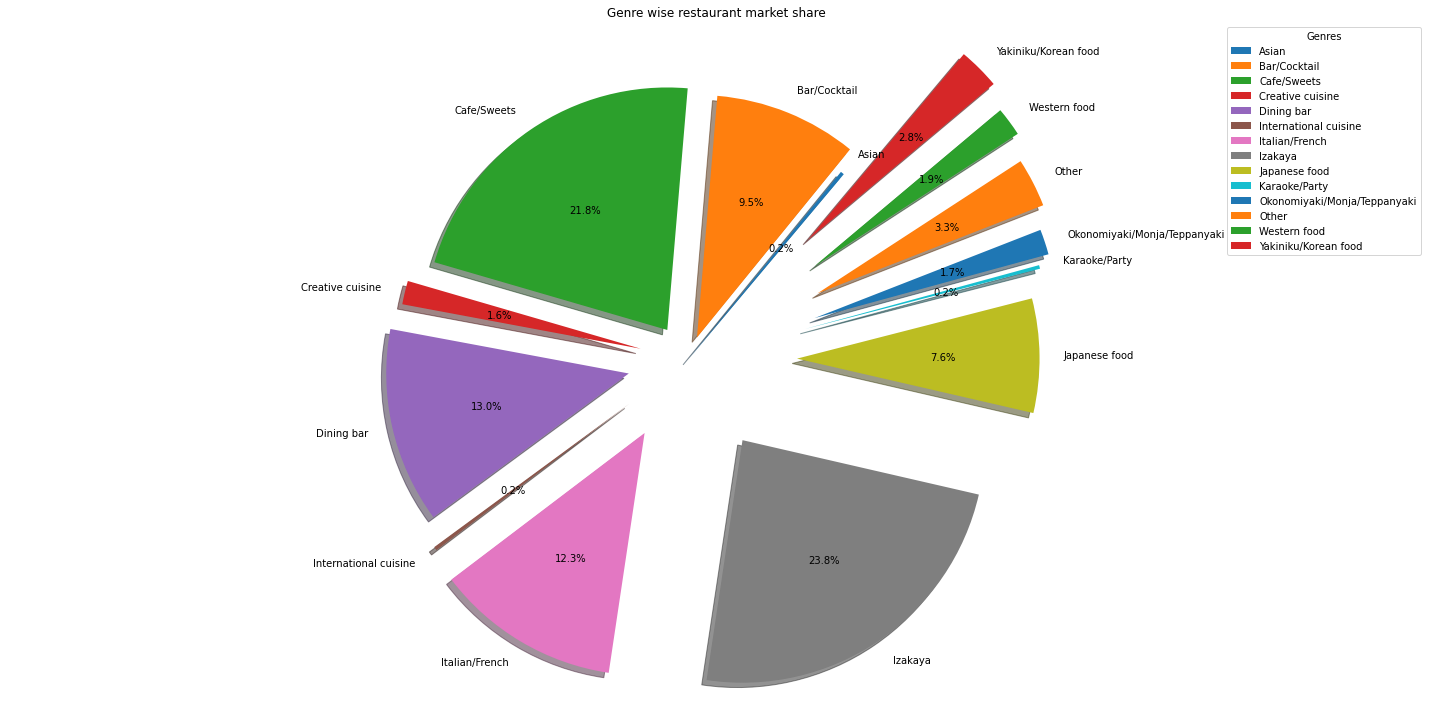

In [270]:
# Pie chart
labels = temp.air_genre_name.values
sizes = temp.air_store_id.values
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.1, 0.15, 0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7)  
fig1, ax1 = plt.subplots(figsize=(20,10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=50)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.legend(title='Genres')
plt.title('Genre wise restaurant market share')
plt.show()

### Observations

1. 일본 레스토랑 종류: 14개
2. 이자카야가 23.8%로 가장 높은 점유율을 보인다.
3. 두 번째는 21.8%에 육박하는 카페/스위츠이다.
3. 대부분 현지 음식이 인기가 많은 편이다.

## 4. 식당 종류별 방문자 수

Text(0.5, 1.0, 'Total visitors by air_genre_name')

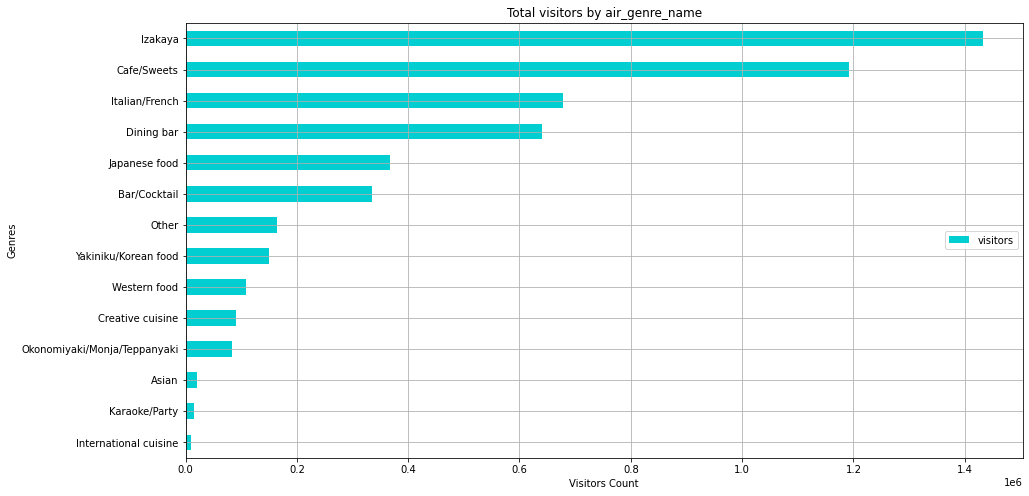

In [271]:
f,ax = plt.subplots(1,1, figsize=(15,8))
genre = full.groupby(['air_genre_name'])['visitors'].sum().to_frame()
genre.sort_values(by='visitors',inplace=True)
genre.plot(kind='barh',color= 'darkturquoise', grid=True, ax=ax, legend=True)
plt.ylabel('Genres')
plt.xlabel('Visitors Count')
plt.legend(loc='center right')
plt.title("Total visitors by air_genre_name", loc='center')

### Observation

1. 1위는 이자카야, 2위는 카페 순으로 방문객 수가 많다. 이는 **식당 수가 많기 때문에 자연스럽게 이어지는 결과**라 볼 수 있다.
2. 3위부터는 양식으로 인기가 서서히 줄어든다.

## 5. 전체 식당 숫자

Text(0.5, 1.0, 'Number Unique Store ID')

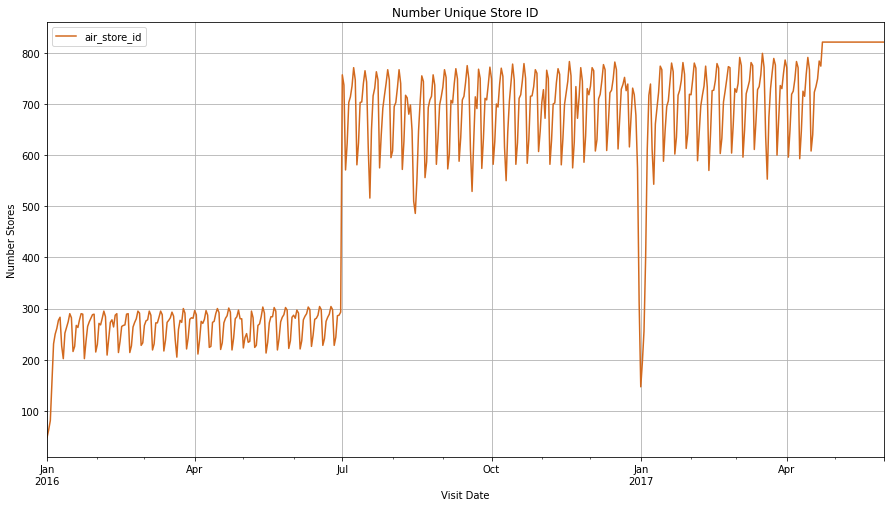

In [272]:
f,ax = plt.subplots(1,1, figsize=(15,8))
stores= full.groupby(['visit_date'])['air_store_id'].size()
stores.plot(kind='line',  color= 'chocolate', grid=True, ax=ax, legend=True)
plt.ylabel("Number Stores")
plt.xlabel("Visit Date")
plt.title("Number Unique Store ID")

### Observation

1. 2016년 중반에 식당 수가 거의 150% 증가
2. 식당의 수는 약 800개 정도라고 볼 수 있다.
3. 2017년이 되는 1월 1일에는 문을 닫기 때문에 급격히 내려가는 것을 볼 수 있음

## 6. 요일별 방문자수

Text(0.5, 1.0, 'Average Visitors Each Day Of Week')

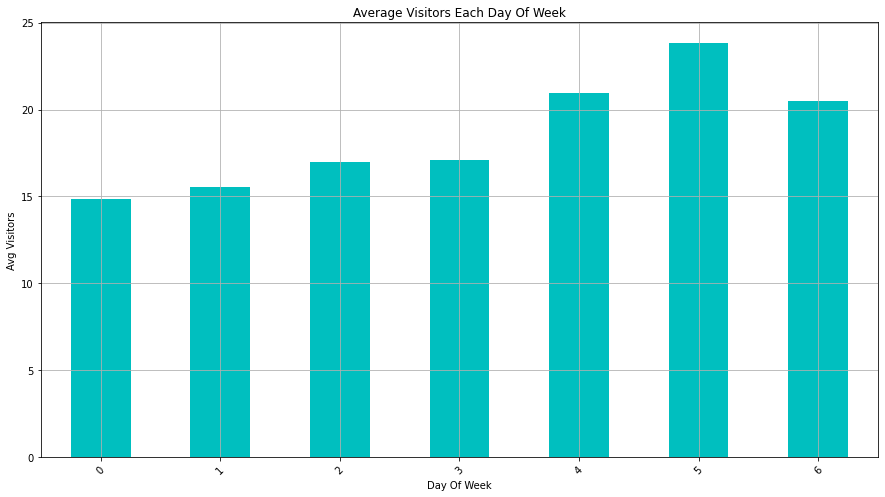

In [273]:
# 요일별 방문자 수
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= full.groupby(['weekday'])['visitors'].mean().to_frame()
temp.plot(kind='bar',color= 'c', grid=True, ax=ax, legend=False)
plt.xticks(rotation=45)
plt.xlabel('Day Of Week')
plt.ylabel('Avg Visitors')
plt.title('Average Visitors Each Day Of Week')

### Observations

0: 월요일 ~ 6: 일요일

1. **금요일, 토요일**에 가장 많이 방문한다.
2. 그 다음으로는 **일요일**이다.
3. **월요일**이 가장 적음

상식적인 결과 그대로 나온다.

## 7. 식당별, 하루 평균 예약건수, 방문자수

In [274]:
# 식당별 하루평균 예약건수, 방문자수
restaurant = full.groupby(['air_store_id'])[['n_reserves', 'n_reserve_visitors']].mean()

In [276]:
group_by_cols = ['air_store_id', 'n_reserves', 'n_reserve_visitors']

restaurant  = full\
                .query('dataset == "past"')\
                .groupby(group_by_cols)\
                ['visitors']\
                .agg(['mean', 'median', 'min', 'max'])\
                .rename(columns=lambda colname: str(colname)+'_visitors')\
                .reset_index()

In [289]:
restaurant.head()

,air_store_id,n_reserves,n_reserve_visitors,mean_visitors,median_visitors,min_visitors,max_visitors
0,air_00a91d42b08b08d9,1.0,1.0,27.444444,28.0,15,39
1,air_00a91d42b08b08d9,1.0,2.0,29.277778,30.5,6,53
2,air_00a91d42b08b08d9,1.0,3.0,25.000000,26.0,5,52
3,air_00a91d42b08b08d9,1.0,4.0,33.666667,36.0,28,37
4,air_00a91d42b08b08d9,1.0,5.0,32.500000,32.5,32,33


In [291]:
restaurant['n_reserves'].mean()

4.143933211976649

In [292]:
restaurant['n_reserve_visitors'].mean()

20.595003452388426

In [277]:
rest_mean = (restaurant['n_reserve_visitors']/restaurant['n_reserves']).mean()
rest_mean

6.433753042497085

### Observation

1. 하루 평균 예약 건수는 약 4건
2. 하루 평균 예약 방문자 수는 20명
3. 예약별 방문자 수 평균은 6명

## 8. 방문자수, 예약수, 예약한 방문자수 비교

Text(0.5, 1.0, 'Visitor and Reservations')

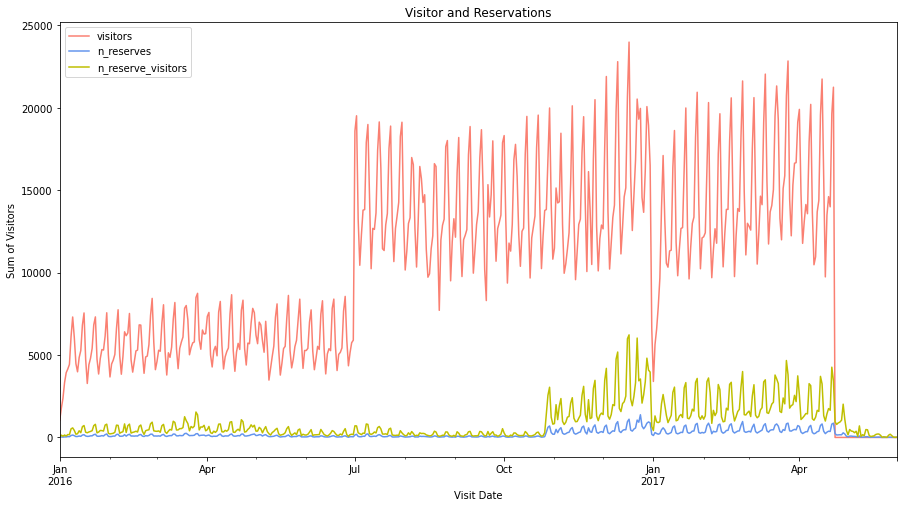

In [278]:
f,ax = plt.subplots(1,1,figsize=(15,8))
plt1 = full.groupby(['visit_date'])['visitors'].sum().to_frame()
plt2 = full.groupby(['visit_date'])['n_reserves'].sum().to_frame()
plt3 = full.groupby(['visit_date'])['n_reserve_visitors'].sum().to_frame()
plt1.plot(color='salmon', kind='line', ax=ax)
plt2.plot(color='cornflowerblue', kind='line', ax=ax)
plt3.plot(color='y', kind='line', ax=ax)
plt.legend()
plt.ylabel("Sum of Visitors")
plt.xlabel("Visit Date")
plt.title("Visitor and Reservations")

### Observation

**미리 예약을 하지 않은 손님**이 **예약한 손님보다 훨씬 많다는 것**을 알 수 있음

## 9. 예약한 사람들의 평균 방문 시간

In [311]:
reserves['visit_hour'] = reserves['visit_datetime'].dt.hour

In [312]:
reserves.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,datetime_gap,hours_gap,days_gap,visit_date,visit_hour
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,0 days 03:00:00,3.0,0,2016-01-01,19
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,0 days 00:00:00,0.0,0,2016-01-01,19
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,0 days 00:00:00,0.0,0,2016-01-01,19
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,0 days 04:00:00,4.0,0,2016-01-01,20
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,0 days 19:00:00,19.0,0,2016-01-01,20


Text(0.5, 1.0, 'Hourly Registrations')

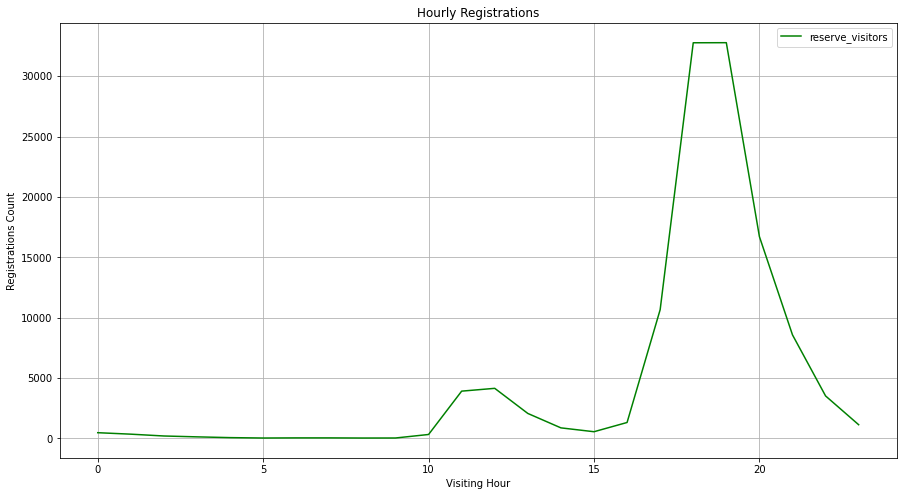

In [314]:
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= reserves.groupby(['visit_hour'])['reserve_visitors'].count().to_frame()
temp.plot(kind='line',color= 'g', grid=True, ax=ax,legend=True)
plt.xlabel('Visiting Hour')
plt.ylabel('Registrations Count')
plt.title('Hourly Registrations')

### Observation

1. 예약한 사람들은 **16시 이후** 방문이 급격히 증가
2. **약 17~19시 사이** 가장 많이 방문한다.
3. 예약의 대부분이 저녁 식사였음을 알 수 있다.

# Label Encoding

In [29]:
full.columns

Index(['dataset', 'air_store_id', 'visit_date', 'visitors', 'id', 'weekday',
       'year', 'month', 'day_of_year', 'is_month_end', 'holiday_flg',
       'tomorrow_is_holiday', 'yesterday_is_holiday', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'Todofuken', 'city', 'street',
       'n_stores_same_street', 'n_stores_same_city', 'n_stores_same_Todofuken',
       'n_reserves', 'n_reserve_visitors', 'reserve_avg_hours_ahead',
       'max_reserve_visitors'],
      dtype='object')

In [30]:
# 불필요한 변수 제거
full.drop(columns=['air_store_id', 'air_area_name', 'visit_date'], inplace=True)

In [31]:
full.shape

(284127, 24)

In [32]:
from sklearn.preprocessing import LabelEncoder

# 범주형 변수
cat_cols = ['is_month_end', 'air_genre_name','Todofuken', 'city', 'street']

for cat in cat_cols:
    encoder = LabelEncoder()
    full[cat] = encoder.fit_transform(full[cat].astype(str))

In [33]:
# 전처리 데이터 저장
full.to_csv('scratch/full_engineering.csv', index=False)